# Movie Reviews Classification

# Library

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')

# Normalize text
import re
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelBinarizer

# Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix

# Vizualisation
import matplotlib.pyplot as plt

from IPython.display import clear_output
clear_output(wait=False)

# Importing and analysing data

In [2]:
data = pd.read_csv("./data/IMDB_Dataset.csv", converters={"review": lambda x: x.lower()})
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


The data set is balanced, this is very important to not get any bias.

In [3]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# Splitting data into training and testing data sets
The training set will consist of 2 thirds of the original data set with an even number of positive and negative reviews.

The testing set will consist of a third of the original data set, we won't make it balanced, we'll take one random third of the last rows.

In [4]:
positive_set = data.loc[data['sentiment'] == 'positive']
training_set = positive_set.iloc[:17500]

In [5]:
negative_set = data.loc[data['sentiment'] == 'negative']
training_set = pd.concat([training_set, negative_set.iloc[:17500]])

In [6]:
del positive_set, negative_set

In [7]:
testing_set = data.iloc[35000:]
testing_set['sentiment'].value_counts()

sentiment
positive    7510
negative    7490
Name: count, dtype: int64

In [8]:
# Shuffling the data sets to remove bias
training_set = training_set.sample(frac=1).reset_index(drop=True)
testing_set = testing_set.sample(frac=1).reset_index(drop=True)

In [9]:
print(training_set.shape)
training_set.head()

(35000, 2)


,review,sentiment
0,"after a cold sex scene, between andy and gina,...",positive
1,practically the only other actor who would be ...,negative
2,it's really good to see van damme's film are s...,positive
3,the earlier part of the film was rather enjoya...,negative
4,jay craven's criminally ignored film is a sobe...,positive


In [10]:
print(testing_set.shape)
testing_set.head()

(15000, 2)


,review,sentiment
0,it is said that there are some people out ther...,negative
1,i happened to catch this movie on late night t...,negative
2,this movie from what i remember was such a gre...,positive
3,"fashionably fragmented, yet infuriatingly half...",negative
4,another british cinema flag waver. real garbag...,negative


# Normalizing data

To classify text, we have to normalize it so a computer can understand it.

The steps will be :

- Putting all the text in lower case (With the converters parameter of read_csv, we already did this step.)
- Removing punctuation and html specific keyword (such as < br/ >) : we'll use re and BeautifulSoup.
- Transforming the text into tokens
- Removing any stopword : it consists of removing words with poor semantic interest, nltk has a built in list to which I'll add the words "movie" and "review".
- Using a lemmatizer on the text : it consists of using the same word for derivatives of said word, removing conjugation from verbs, plural from words etc.



## Tools used to normalize the text

In [11]:
# We'll use a simple, general tokeniser
toktoktokeniser = ToktokTokenizer()

In [12]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("movie")
stopwords.append("review")

In [13]:
def normalize_text(text):
    # lower case -> done in read_csv
    # removing html specific keywords
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # removing all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # transforming txt into tokens
    tokens = toktoktokeniser.tokenize(text)
    # removing stopwords
    tokens_to_filter = [token.strip() for token in tokens]
    tokens = [token for token in tokens_to_filter if token not in stopwords]
    
    # using a lemmatizer on the text
    lemma = WordNetLemmatizer()
    final_tokens = [lemma.lemmatize(word) for word in tokens]
    text = ' '.join(final_tokens)
    return text

## Normalized data sets

In [14]:
norm_training_set = training_set.copy()
norm_training_set['review'] = training_set['review'].apply(normalize_text)
clear_output(wait=False)
norm_training_set

,review,sentiment
0,cold sex scene andy gina south america know an...,positive
1,practically actor would le likely play evel kn...,negative
2,really good see van dammes film slowly getting...,positive
3,earlier part film rather enjoyable towards end...,negative
4,jay craven criminally ignored film sober breat...,positive
...,...,...
34995,never seen terrible ive gone insane huge waste...,negative
34996,watching beginning end happened catch last hal...,positive
34997,cause showcase sean connery harvard law prof k...,negative
34998,wow james purefoy look exactly like thomas jan...,negative


In [15]:
norm_testing_set = testing_set.copy()
norm_testing_set['review'] = testing_set['review'].apply(normalize_text)
clear_output(wait=False)
norm_testing_set

,review,sentiment
0,said people actually admire monogram movie wel...,negative
1,happened catch late night tv saw opening credi...,negative
2,remember great watched television 11 couldnt r...,positive
3,fashionably fragmented yet infuriatingly halfr...,negative
4,another british cinema flag waver real garbage...,negative
...,...,...
14995,actually looking forward commercial made look ...,negative
14996,went cinema 1973 film released 11 time remembe...,positive
14997,john wayne first starring role blew away telev...,positive
14998,1904 tangier wealthy american woman two child ...,negative


# Labelizing the sentiment column

In [16]:
lb=LabelBinarizer()

train_sentiment = lb.fit_transform(training_set['sentiment'])
test_sentiment = lb.fit_transform(testing_set['sentiment'])

# Term Frequency - Inverse Document Frequency (TFIDF)
TFIDF represents words with a number matrix. 

We'll use the parameter ngram (1,2) to get a bit more context with tuple of words.

Careful not to use fit_transform on the testing set, only fit_transform on the training set.

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2))
tfid_train = tfidf_vectorizer.fit_transform(training_set.review)
tfid_test = tfidf_vectorizer.transform(testing_set.review)

In [18]:
print('Tfidf_train:', tfid_train.shape)
print('Tfidf_test:', tfid_test.shape)

Tfidf_train: (35000, 2311168)
Tfidf_test: (15000, 2311168)


## CountVectorizer : an alternative to tfidf

```
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
tfid_train = count_vectorizer.fit_transform(training_set.review)
tfid_test = count_vectorizer.transform(testing_set.review)
print('Tfidf_train:', tfid_train.shape)
print('Tfidf_test:', tfid_test.shape)
```

# Stochastic Gradient Descent

## Model

In [19]:
sgdc_model = SGDClassifier(loss='hinge',max_iter=500,random_state=42)
sgdc_model = sgdc_model.fit(tfid_train, train_sentiment)
clear_output(wait=False)

## Prediction results on testing set

In [20]:
sgdc_prediction = sgdc_model.predict(tfid_test)
sgdc_prediction

array([0, 0, 1, ..., 1, 1, 0])

### Classification report

In [21]:
print(classification_report(test_sentiment, sgdc_prediction,target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.91      0.87      0.89      7490
    Negative       0.87      0.91      0.89      7510

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



### Confusion Matrix

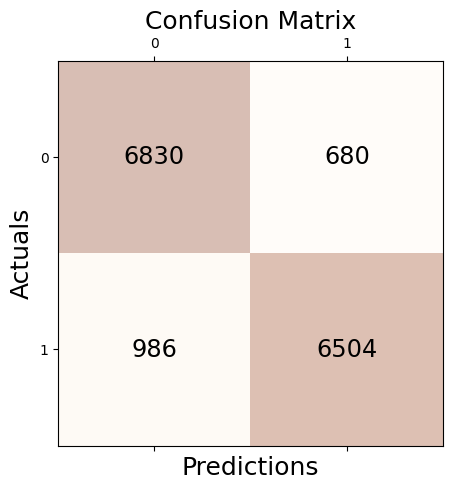

The confusion matrix shows us the number of :

* True positives : 6830 

* False positives : 680 

* False negatives: 986 

* True negatives: 6504 



In [23]:
conf_matrix = confusion_matrix(test_sentiment, sgdc_prediction, labels=[1,0])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* False positives :', conf_matrix[0][1],'\n')
print('* False negatives:', conf_matrix[1][0] ,'\n')
print('* True negatives:', conf_matrix[1][1] ,'\n')